In [ ]:
%pip install statsmodels  #tensorflow,scikit-learn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#tensorflow,scikit-learn'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install hmmlearn

   ---------------------------------------- 0.0/127.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/127.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/127.0 kB ? eta -:--:--
   ------ --------------------------------- 20.5/127.0 kB ? eta -:--:--
   --------------- ----------------------- 51.2/127.0 kB 660.6 kB/s eta 0:00:01
   ------------------------------ ------- 102.4/127.0 kB 845.5 kB/s eta 0:00:01
   -------------------------------------- 127.0/127.0 kB 934.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [4]:
from hmmlearn import hmm

In [32]:
# Load the dataset
df = pd.read_csv('weather_data.csv')
print(df.head())


         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  


In [33]:
# Encode the target variable
df['rain_or_not'] = df['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

# Calculate initial rain/no rain counts and percentages
initial_rain_count = (df['rain_or_not'] == 1).sum()
initial_no_rain_count = (df['rain_or_not'] == 0).sum()
initial_total = len(df)
initial_rain_percentage = (initial_rain_count / initial_total) * 100
initial_no_rain_percentage = (initial_no_rain_count / initial_total) * 100

print("Initial Rain/No Rain Counts:")
print(f"Rain: {initial_rain_count} ({initial_rain_percentage:.2f}%)")
print(f"No Rain: {initial_no_rain_count} ({initial_no_rain_percentage:.2f}%)")
print(f"Total: {initial_total}")
print("-" * 30)


Initial Rain/No Rain Counts:
Rain: 198 (63.67%)
No Rain: 113 (36.33%)
Total: 311
------------------------------


In [34]:
# Remove rows with missing values
df_cleaned = df.dropna()

# Calculate cleaned rain/no rain counts and percentages
cleaned_rain_count = (df_cleaned['rain_or_not'] == 1).sum()
cleaned_no_rain_count = (df_cleaned['rain_or_not'] == 0).sum()
cleaned_total = len(df_cleaned)

cleaned_rain_percentage = (cleaned_rain_count / cleaned_total) * 100
cleaned_no_rain_percentage = (cleaned_no_rain_count / cleaned_total) * 100

print("Cleaned Rain/No Rain Counts (after removing missing values):")
print(f"Rain: {cleaned_rain_count} ({cleaned_rain_percentage:.2f}%)")
print(f"No Rain: {cleaned_no_rain_count} ({cleaned_no_rain_percentage:.2f}%)")
print(f"Total: {cleaned_total}")


Cleaned Rain/No Rain Counts (after removing missing values):
Rain: 189 (63.85%)
No Rain: 107 (36.15%)
Total: 296


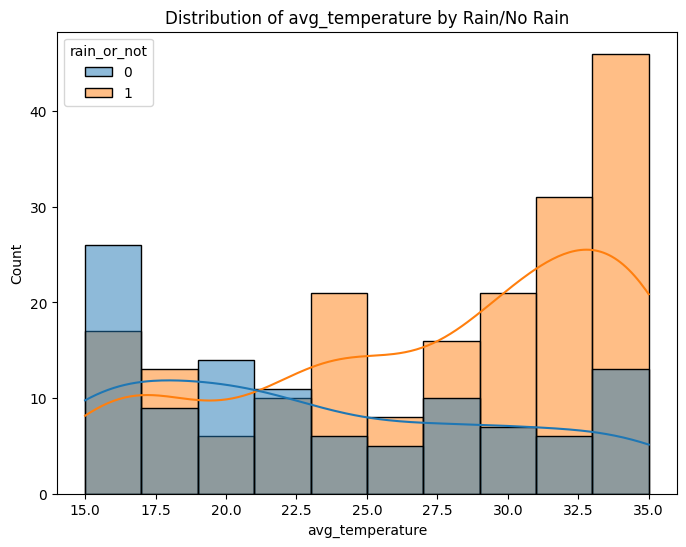

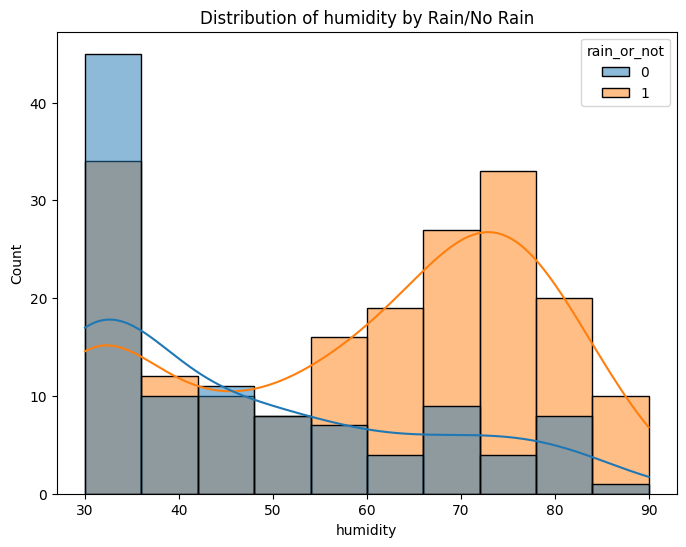

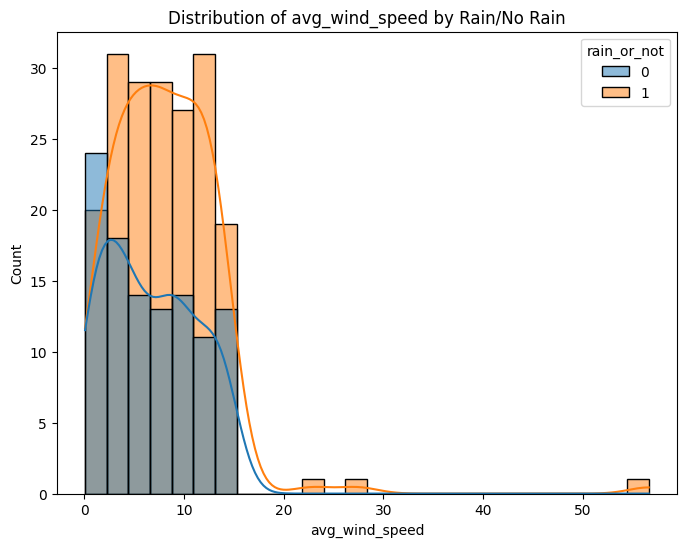

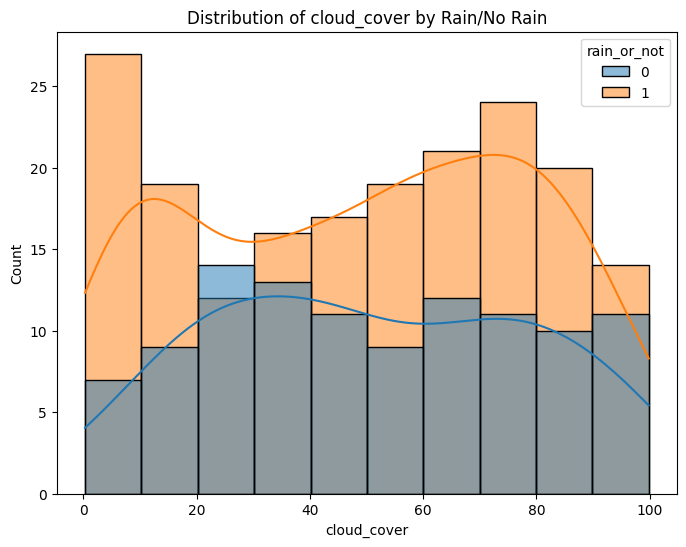

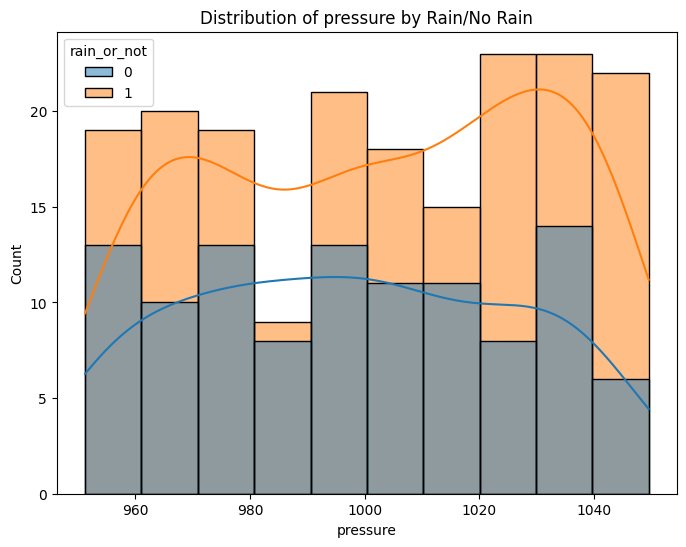

In [35]:
features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Histograms
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_cleaned, x=feature, hue='rain_or_not', kde=True)
    plt.title(f'Distribution of {feature} by Rain/No Rain')
    plt.show()


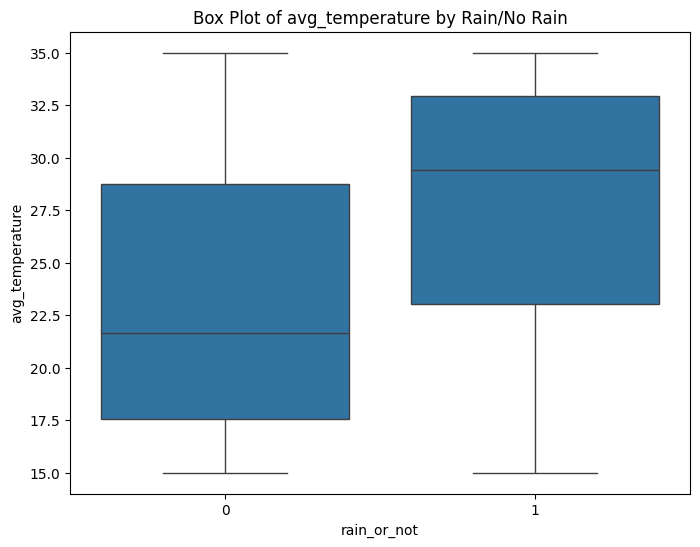

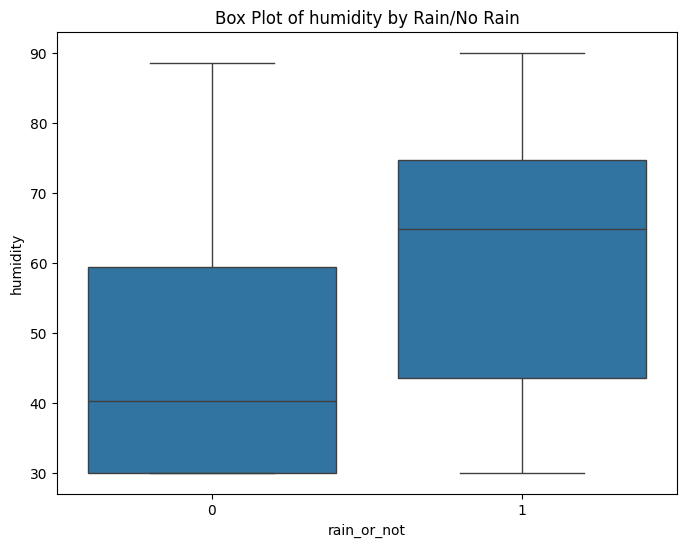

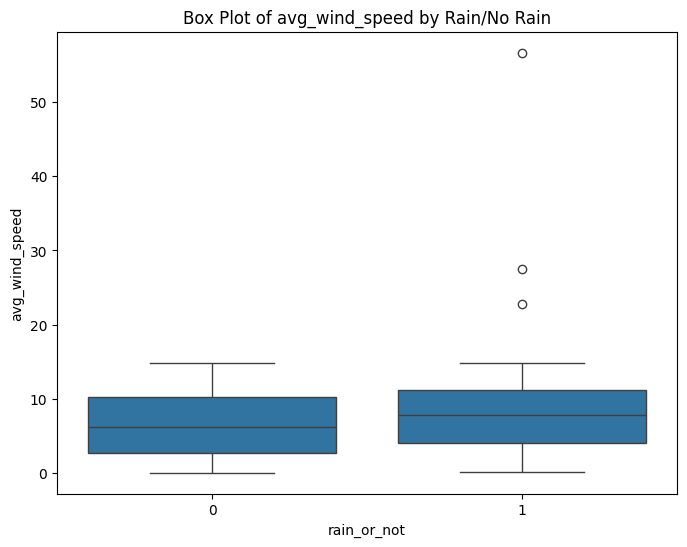

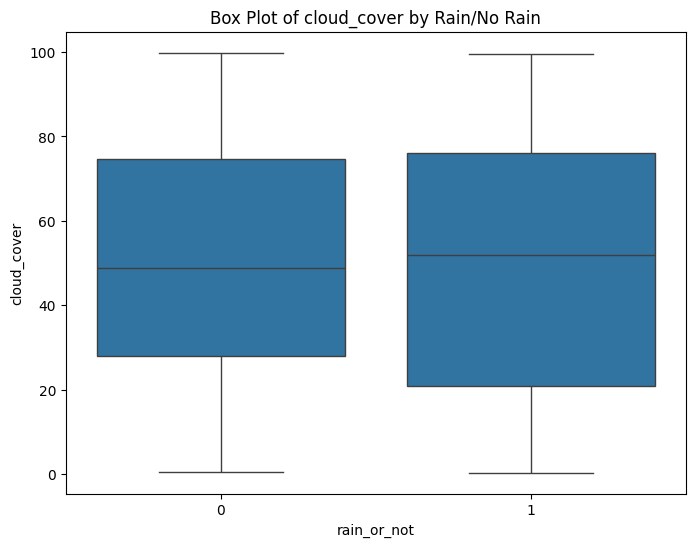

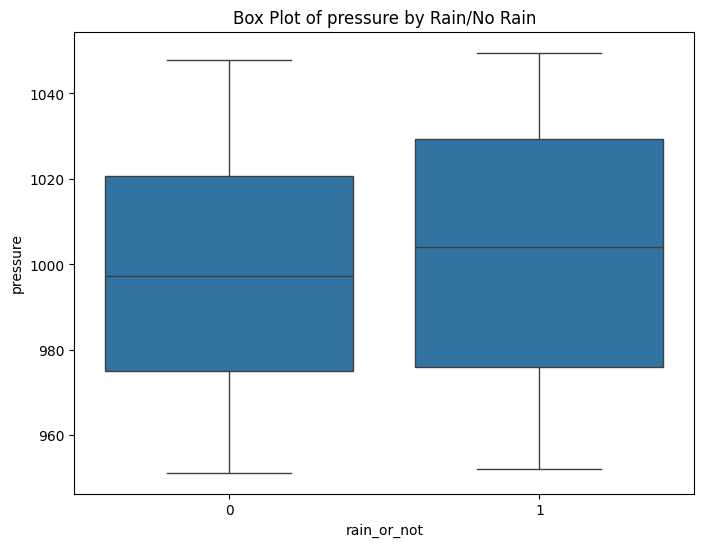

In [36]:
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='rain_or_not', y=feature, data=df_cleaned)
    plt.title(f'Box Plot of {feature} by Rain/No Rain')
    plt.show()


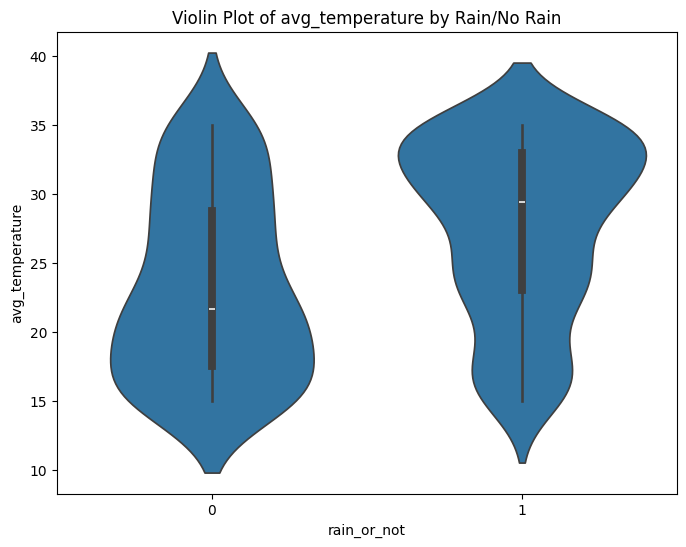

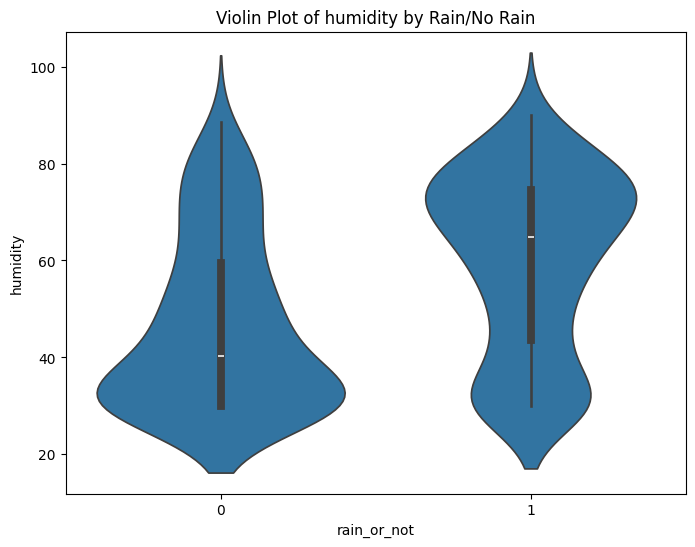

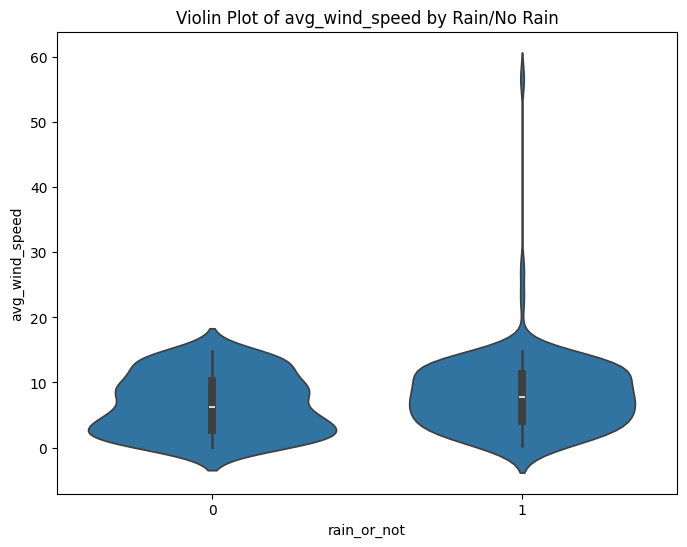

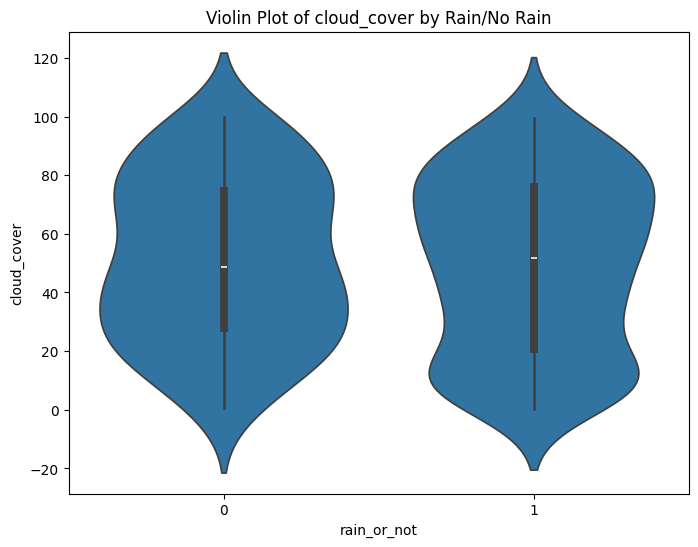

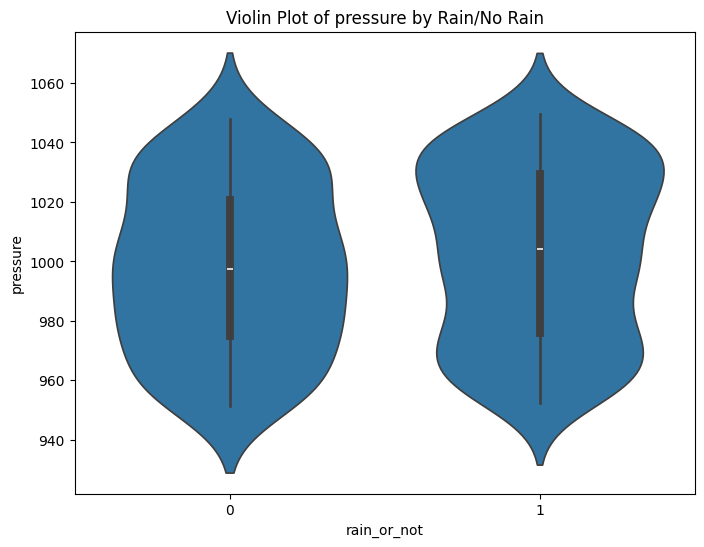

In [37]:
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='rain_or_not', y=feature, data=df_cleaned)
    plt.title(f'Violin Plot of {feature} by Rain/No Rain')
    plt.show()


In [38]:
for feature in features:
    correlation, p_value = pointbiserialr(df_cleaned[feature], df_cleaned['rain_or_not'])
    print(f"Point Biserial Correlation between {feature} and rain_or_not: {correlation:.4f}, p-value: {p_value:.4f}")


Point Biserial Correlation between avg_temperature and rain_or_not: 0.3027, p-value: 0.0000
Point Biserial Correlation between humidity and rain_or_not: 0.3303, p-value: 0.0000
Point Biserial Correlation between avg_wind_speed and rain_or_not: 0.1290, p-value: 0.0264
Point Biserial Correlation between cloud_cover and rain_or_not: -0.0350, p-value: 0.5485
Point Biserial Correlation between pressure and rain_or_not: 0.0823, p-value: 0.1576


In [39]:
rain_list = df_cleaned['rain_or_not'].tolist()

def calculate_conditional_probabilities(rain_list, n):
    rain_given_rainy_days = 0
    rainy_days_count = 0
    rain_given_non_rainy_days = 0
    non_rainy_days_count = 0

    for i in range(n, len(rain_list)):
        if all(rain_list[i-j] == 1 for j in range(1, n+1)):
            rainy_days_count += 1
            if rain_list[i] == 1:
                rain_given_rainy_days += 1
        if all(rain_list[i-j] == 0 for j in range(1, n+1)):
            non_rainy_days_count += 1
            if rain_list[i] == 1:
                rain_given_non_rainy_days += 1

    prob_rain_given_rainy = rain_given_rainy_days / rainy_days_count if rainy_days_count > 0 else 0
    prob_rain_given_non_rainy = rain_given_non_rainy_days / non_rainy_days_count if non_rainy_days_count > 0 else 0

    return prob_rain_given_rainy, prob_rain_given_non_rainy

n = 9
prob_rain_given_rainy, prob_rain_given_non_rainy = calculate_conditional_probabilities(rain_list, n)

print(f"Probability of rain given last {n} days were rainy: {prob_rain_given_rainy:.4f}")
print(f"Probability of rain given last {n} days were not rainy: {prob_rain_given_non_rainy:.4f}")


Probability of rain given last 9 days were rainy: 0.8462
Probability of rain given last 9 days were not rainy: 0.0000


In [40]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned = df_cleaned.sort_values('date')
print(df_cleaned.head())


        date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0 2023-01-01        23.745401  46.140905        7.845981            1   
1 2023-01-02        30.030503  59.876587        5.382457            1   
2 2023-01-03        28.365224  51.464618       13.158008            1   
3 2023-01-04        27.550929  53.103799        5.886677            1   
4 2023-01-05        23.639303  57.826186       12.248992            1   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  


C:\Users\lokud\AppData\Local\Temp\ipykernel_32804\4074001061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])


In [41]:
train_df = df_cleaned[:-21]
eval_df = df_cleaned[-21:]

data = train_df['rain_or_not'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

look_back = 50
X_train, y_train = [], []
for i in range(look_back, len(data)):
    X_train.append(data[i - look_back:i])
    y_train.append(data[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32)


C:\Users\lokud\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5083 - loss: 0.6904
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5650 - loss: 0.6908
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5705 - loss: 0.6955
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5613 - loss: 0.6924
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5477 - loss: 0.6959
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5892 - loss: 0.6783
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5655 - loss: 0.6835
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5811 - loss: 0.6797
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5695 - loss: 0.6826
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5835 - loss: 0.6781
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5771 - loss: 0.6765
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5741 - loss: 0.6822
E

In [42]:
full_data = df_cleaned['rain_or_not'].values.reshape(-1, 1)
full_data_scaled = scaler.transform(full_data)

X_full = []
for i in range(look_back, len(full_data_scaled)):
    X_full.append(full_data_scaled[i - look_back:i])

X_full = np.array(X_full)
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))

predictions = model.predict(X_full[-21:])
y_eval = eval_df['rain_or_not'].values

threshold = 0.57
binary_predictions = [1 if p > threshold else 0 for p in predictions]

accuracy = accuracy_score(y_eval, binary_predictions)
precision = precision_score(y_eval, binary_predictions)
recall = recall_score(y_eval, binary_predictions)
f1 = f1_score(y_eval, binary_predictions)
auc = roc_auc_score(y_eval, predictions)
cm = confusion_matrix(y_eval, binary_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Accuracy: 0.4286
Precision: 0.5000
Recall: 0.2500
F1-score: 0.3333
AUC: 0.6019
Confusion Matrix:
[[6 3]
 [9 3]]
